# Project 2: The Linear-Nonlinear Model

Over the last two and a half days, you've learned how to analyze spike trains recorded under visual stimulation and also calculate the spike-triggered average (STA). As a final project in this course, you will turn to a very common modelling tool used in sensory systems neuroscience, the linear-nonlinear (LN) model.

The LN model provides a simple way to predict a neuron's response to novel stimuli. At it's core, the model assumes that the more similar a stimulus is to the cell's STA, the more the cell will fire. The similarity measure is a **linear** mathematical operation called a *convolution*, and the relationship between the result of the convolution and the cell's spiking output is **non-linear**. This combination of **linear + non-linear** is the reason the LN model is called the way it is called.

This brings the LN model down to three steps:

- compute the cell's STA
- compute the convolution between the receptive field and the stimulus
- find / fit the non-linear relationship between the "similarity" measure and the firing rate

At the end of this project, you'll be able to use the LN model to predict the responses of retinal ganglion cells.

Let's begin by importing the required packages and defining some helper functions:

In [1]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 6), 'font.size': 14 }

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from numpy import load
from pathlib import Path

In [2]:
### HELPER FUNCTIONS ###
# Please run this cell #
# before starting with #
#     the notebook     #
########################


def plot_rasters(
    response_matrix: np.ndarray,
    ax: plt.Axes,
    sampling_rate: float,
    **kwargs
):
    for t, trial in enumerate(response_matrix):
        spike_list = []
        for c, spike_count in enumerate(trial):
            if spike_count > 0:
                spike_list.extend((np.random.random(size=spike_count) + c).tolist())

        if spike_list:
            ax.plot(
                np.array(spike_list) / sampling_rate,
                [1 + t] * len(spike_list),
                **kwargs
            )
    ax.invert_yaxis()

    return ax

Earlier today, you learned how to compute the STA for a cell given the cell's response to a certain stimulus. This means **you've already implemented the first step of the LN model!** This also means we'll be able to re-use some of the functions we wrote earlier. These have been carried over and defined for you.

In [3]:
def calculate_sta(
    spike_times_array,
    stimulus_array,
    pulses_array, 
    training_frames,
    test_frames,
    past_frames,
):
    """
    Compute a cell's spike-triggered average (STA) given it's responses to a visual stimulus.
    """
    # reshape the stimulus and pulses using the training_frames and test_frames
    stimulus_reshaped, pulses_reshaped = get_reshaped_stimulus_and_pulses(
        stimulus_array,
        pulses_array,
        training_frames,
        test_frames
    )
    
    # select only those spikes which occur during the stimulus presentation
    spikes_in_stimulus = spike_times_array[  # select...
        (spike_times_array > pulses_reshaped.ravel()[0]) &  # ... all spikes after the first pulse
        (spike_times_array < pulses_reshaped.ravel()[-1])  # ... and all spikes before the last pulse
    ]
    
    # bin the spike train using the reshaped pulses
    spikes_binned = compute_binned_spikes(
        spikes_in_stimulus,
        pulses_reshaped
    )
    
    # reshape the binned spikes to the same shape as reshaped_pulses
    spikes_in_trials = np.reshape(spikes_binned, reshaped_pulses.shape)
    
    # split spikes into training and test
    training_spikes, _ = split_into_two(
        spikes_in_trials,
        training_frames
    )
    
    # split stimulus into training and test
    training_stimulus, _ = split_into_two(
        stimulus_reshaped,
        training_frames
    )
    
    # get stimulus snippets past_frames before each spike
    stimulus_snippets = get_stimulus_stack(
        training_spikes,
        training_stimulus,
        past_frames
    )
    
    # average over the stimulus snippets
    sta = stimulus_snippets.mean(axis=0)
    
    return sta


def get_stimulus_stack(training_spikes_array, training_stimulus, past_frames):
    """
    Extract stimulus values before each spike in the training set, ignoring
    the first past_frames bins.
    """
    snippets = []  # create an empty list
    
    for t, trial in enumerate(training_spikes_array):  # loop over trials
        for b, bin_count in enumerate(trial):  # loop over bins in trial
            # only for bins after first past_frames frames
            if (b + 1 >= past_frames) \
               and (bin_count > 0):  # and only for bins which have at least 1 spike
                snippet = training_stimulus[
                    t, b + 1 - past_frames:b + 1
                ]  # cut out past_frames frames before the spike from the stimulus
                for i in range(bin_count):  # append once to list for every spike in bin
                    snippets.append(snippet)
    
    return np.array(snippets)  # return a numpy array


def compute_binned_spikes(spike_times_array, reshaped_pulses_array):
    """
    Bin spikes according to the bin edges defined by the pulses.
    """
    binned_spike_array = np.bincount(
        np.digitize(
            x=spike_times_array,
            bins=reshaped_pulses_array.ravel(),
        ) - 1,  # important to make sure the bin ids of the spikes align with the stimulus
        minlength=reshaped_pulses.size
    )
    
    return binned_spike_array


def split_into_two(two_dimensional_array, split_id):
    """
    Split the input 2d-array along its second dimension into two sets at split_id.
    """
    first_array = two_dimensional_array[:, :split_id]
    second_array = two_dimensional_array[:, split_id:]
    
    return first_array, second_array


def get_reshaped_stimulus_and_pulses(stimulus_array, pulses_array, training_frames, test_frames):
    """
    Return the stimulus and pulses arrays reshaped to (trials x frames).
    """    
    # compute the total number of trials in the experiment
    frames_per_trial = training_frames + test_frames
    total_trials = int(np.floor(pulses_array.size / frames_per_trial))
    
    # truncate stimulus and pulses to match the total number of complete trials
    pulses_array = pulses_array[:total_trials * frames_per_trial]
    stimulus_array = stimulus_array[:total_trials * frames_per_trial]
    
    # reshape stimulus and pulses
    pulses_reshaped = np.reshape(pulses_array, (total_trials, frames_per_trial))
    stimulus_reshaped = np.reshape(stimulus_array, (total_trials, frames_per_trial))
    
    return stimulus_reshaped, pulses_reshaped

# 1 - The stimulus

For this project, you will work with the same stimulus that you worked with this morning. As a quick recap, the full-field flicker consists of a screen-wide presentation of contrast levels that change with a given frequency (here 75Hz). The contrast value of each presentation is calculated from a number that's been drawn from a Gaussian distribution of mean zero and standard deviation 0.3, with positive values representing brighter, negative values darker presentations.

This is what it looks like:

<center><img src="images/fff.gif" width="200"></center>

The stimulus consists of a **training set** and a **test set**. The training set **does not repeat in trials** whereas the test set **remains the same across trials**. The test set is repeated in every trial to account for any variability, for eg. from experimental noise, that may arise in the cell's responses. 

The model will be evaluated on the average response of the cell to the test stimulus across trials. This also means you'll be making use of the test set in this notebook.

<p><center><img src="images/FFFstimstructure.png" width="600" height="400"></center></p>

# 2 - Load the data

To begin with, let us load the stimulus and pulses:

In [4]:
pulses_filepath = 'data_LN_model/frametimes_fullfieldnoise.txt'
pulses = np.loadtxt(pulses_filepath)

## Each pulse marks a change in stimulus presentation

In [5]:
stimulus_filepath = 'data_LN_model/stimulus_fullfieldnoise.txt'
stimulus = np.loadtxt(stimulus_filepath)

## Each value is a contrast value of the screen.

For now, you will again work with a single cell. So load up the spike times for that cell:

In [6]:
st_filepath = 'data_LN_model/fullfieldnoise_C6.txt'
spike_times = np.loadtxt(st_filepath)

Next, let us define some of the important variables that we used earlier:

In [7]:
nframes_training = 1800
nframes_test = 600
num_past_pulses = 45

**Recap:** use the functions we carried over to reshape the stimulus and pulses arrays into the shape `(trials x frames)`.

In [8]:
## START CODE HERE ##



## END CODE HERE ##

In [9]:
## SOLUTION ##

reshaped_stimulus, reshaped_pulses = get_reshaped_stimulus_and_pulses(
    stimulus,
    pulses,
    nframes_training,
    nframes_test,
)

In [10]:
print(reshaped_stimulus.shape)
print(reshaped_pulses.shape)

(41, 2400)
(41, 2400)


**Expected output:**
```
(41, 2400)
(41, 2400)
```

**Recap:** prepare the spike trains, by selecting spikes only those spikes relevant for the stimulus, binning them and reshaping them into trials.

In [11]:
## START CODE HERE ##

stimulus_spiketimes = spike_times[  # select...
      # ... all spikes after the first pulse
      # ... and all spikes before the last pulse
]

binned_spikes = 

spikes_in_trials = 

## END CODE HERE ##

SyntaxError: invalid syntax (189631159.py, line 6)

In [12]:
## SOLUTION ##

stimulus_spiketimes = spike_times[  # select...
    (spike_times > reshaped_pulses.ravel()[0]) &  # ... all spikes after the first pulse
    (spike_times < reshaped_pulses.ravel()[-1])  # ... and all spikes before the last pulse
]

binned_spikes = compute_binned_spikes(stimulus_spiketimes, reshaped_pulses)

spikes_in_trials = binned_spikes.reshape(reshaped_pulses.shape)

In [13]:
spikes_in_trials.shape

(41, 2400)

**Expected output:**
```
(41, 2400)
```

Lastly, you need to divide the binned spike trains into training and test sets

**Exercise:** split the binned spike trains into training and test sets

*Hint:* you can use functions we've already defined above

In [14]:
## START CODE HERE ##


## END CODE HERE ##

In [15]:
## SOLUTION ##

training_spikes, test_spikes = split_into_two(spikes_in_trials, nframes_training)

In [16]:
print(training_spikes.shape)
print(test_spikes.shape)

(41, 1800)
(41, 600)


**Expected output:**
```
(41, 1800)
(41, 600)
```

Before diving head long into the modelling itself, it might be worth looking at what exactly we want to be able to model / predict in the end.

### Visualizing the ground truth

Each trial in the stimulus has a training and a test set. Throughout the previous session on STAs, you focused on the training set, but what you actually want to predict are the cell's responses to the test set.

More specifically, you want to be able to predict the **cell's average response to the test set**. So, let's calculate that quickly.

**Exercise:** compute the average response of the cell to the test set and call it `ground_truth`

*Hint:* the average here is across trials

In [17]:
## START CODE HERE ##


## END CODE HERE ##

In [18]:
## SOLUTION ##

ground_truth = test_spikes.mean(axis=0)

In [19]:
print(ground_truth[:10])  # first ten bins
print(ground_truth[-10:])  # last ten bins

[0.         0.19512195 0.19512195 0.07317073 0.09756098 0.04878049
 0.09756098 0.12195122 0.         0.04878049]
[0.56097561 0.43902439 0.19512195 0.17073171 0.         0.04878049
 0.04878049 0.12195122 0.02439024 0.04878049]


**Expected output:**
```
[0.         0.19512195 0.19512195 0.07317073 0.09756098 0.04878049
 0.09756098 0.12195122 0.         0.04878049]
[0.56097561 0.43902439 0.19512195 0.17073171 0.         0.04878049
 0.04878049 0.12195122 0.02439024 0.04878049]
```

Let's also plot this!

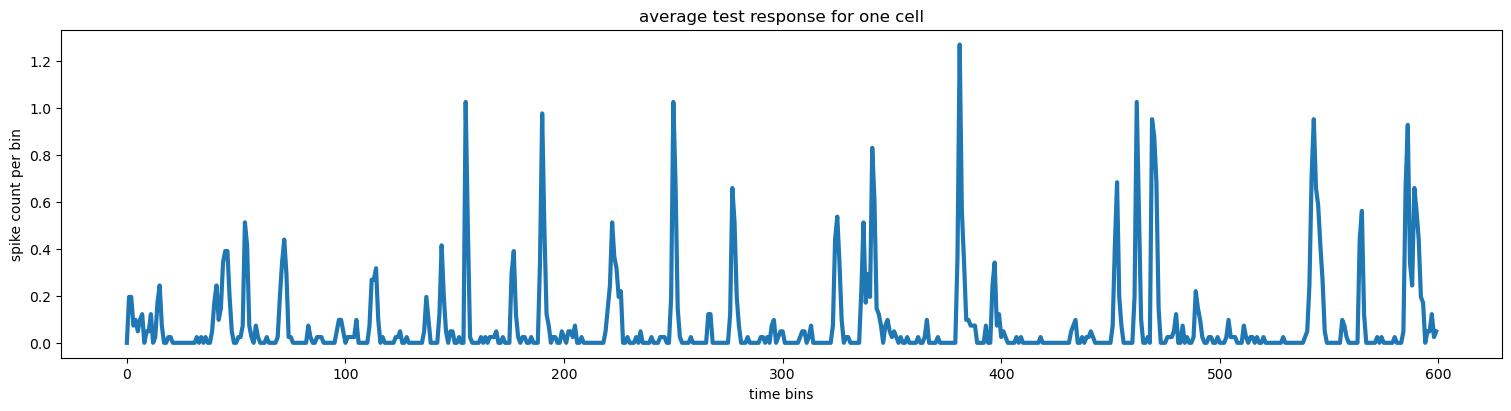

In [20]:
fig, ax = plt.subplots(figsize=(15, 4), layout="constrained")
ax.plot(ground_truth, lw=3)
ax.set_xlabel("time bins")
ax.set_ylabel("spike count per bin")
ax.set_title("average test response for one cell")
plt.show()

This is the average response of this cell to the test stimulus over 40 trials. Take a minute to examine this plot.

Each sharp increase in the spike count probably came right after a stimulus that cell seemed to like! There were also periods of almost no activity (where the average spike count was zero).

At the end of this notebook, your model should be able to follow this trace at least partially, if not completely.

Let's see if this is the case!

# 3 - Compute the STA

This should be quick!

**Exercise:** using the functions and variables defined earlier, calculate the STA for the cell:

In [21]:
## START CODE HERE ##


## END CODE HERE ##

In [22]:
## SOLUTION ##

sta = calculate_sta(
    spike_times,
    stimulus,
    pulses,
    nframes_training,
    nframes_test,
    num_past_pulses,
)

In [23]:
print(sta.shape)

(45,)


**Expected output:** 

```
(45,)
```

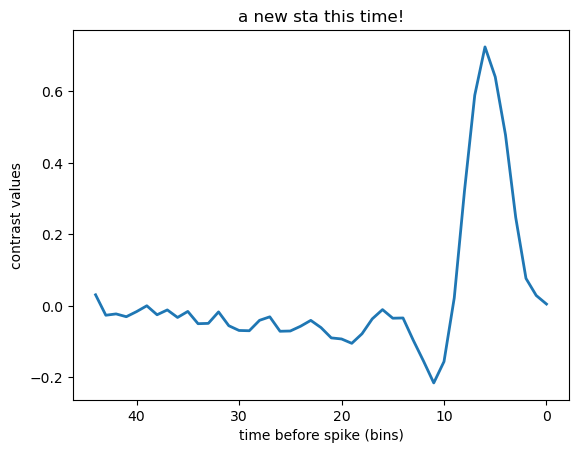

In [24]:
fig, ax = plt.subplots()
ax.plot(sta[::-1], lw=2)
ax.set_xlabel("time before spike (bins)")
ax.set_ylabel("contrast values")
ax.set_title("a new sta this time!")
ax.invert_xaxis()
plt.show()

# 4 - Convolve the stimulus with the STA

### What are convolutions?

Convolution is a mathematical operation that combines two functions to produce a third function. In the context of time-series analysis, convolution allows us to express the relationship between two signals in terms of their overlap.

Given two time-series signals, let's call them **signal** and **kernel**, the convolution of these signals is calculated by sliding the kernel across the signal and multiplying the corresponding values at each position, then summing up the results. This sliding operation effectively measures the similarity between the signals at different time points.

Convolution is widely used in various fields, including signal processing, image processing, and machine learning. It can be utilized for tasks such as filtering, feature extraction, and pattern recognition.

### Example: convolution of two signals

Consider the following graphic:

<center><img src="../images/convolution.gif"></center>

The red curve in the top plot is the **signal** and the green curve sliding across the plot is the **kernel**. The bottom plot shows the result of convolution as the kernel slides over the signal. Each point in the bottom plot is the result of the sum of the element-wise multiplication of the kernel with the signal it overlaps with. As a result, the peak of the triangle corresponds to the point where both the kernel and the signal completely overlap.

### Convolving the stimulus with the STA

In our case, the **signal** is the stimulus and the **kernel** is the STA. The result of their convolution will yield a third signal in which higher values indicate stimuli that resembled the STA.

Since you want to use the training set in the stimulus to train the model, and the test set only to evaluate the model performance, you must first split the `reshaped_stimulus` into training and test sets.

**Exercise:** split the `reshaped_stimulus` into training and test sets, just like you did for the spikes

In [25]:
## START CODE HERE ##



## END CODE HERE ##

In [26]:
## SOLUTION ##

training_stimulus, test_stimulus = split_into_two(reshaped_stimulus, nframes_training)


In [27]:
print(training_stimulus.shape)
print(test_stimulus.shape)

(41, 1800)
(41, 600)


**Expected output:**

```
(41, 1800)
(41, 600)
```

Now, to the convolution itself!

**CAUTION:** the mathematical convention is that the kernel is flipped before convolving with the signal, and this is how the numpy function `convolve` is implemented. This, however, is **not** what you want, so remember to **flip the kernel (STA) before feeding it to the numpy function**.

**Exercise:** complete the function that convolves the stimulus with the STA

*Hint 1:* each trial should be convolved separately (why?), so make sure you loop over the trials

*Hint 2:* use `np.convolve` to do the convolution using the mode "valid"

In [ ]:
def convolve_stimulus_with_sta(stimulus_array, cell_sta):
    """
    Use np.convolve to compute the trial-by-trial convolution
    of the visual stimulus with a cell's spike-triggered avg.
    """
    conv_list = []
    
    ## START CODE HERE ##
    
    
        
    ## END CODE HERE ##
    
    return np.array(conv_list)

In [28]:
def convolve_stimulus_with_sta(stimulus_array, cell_sta):
    """
    Use np.convolve to compute the trial-by-trial convolution
    of the visual stimulus with a cell's spike-triggered avg.
    """
    conv_list = []
    
    ## START CODE HERE ##
    
    for trial in stimulus_array:
        conv = np.convolve(trial, cell_sta[::-1], mode="valid")
        conv_list.append(conv)
        
    ## END CODE HERE ##
    
    return np.array(conv_list)

In [70]:
convolved_signal = convolve_stimulus_with_sta(training_stimulus, sta)

In [71]:
print(convolved_signal.shape)

(41, 1756)


**Expected output:**

```
(41, 1756)
```

In [72]:
print(convolved_signal[0, :10])

[ 0.01918968  0.0602421   0.36939166  1.25714688  2.16611479  3.07741314
  3.25738088  2.57900842  0.64823481 -1.22908584]


**Expected output:**
```
[ 0.01918968  0.0602421   0.36939166  1.25714688  2.16611479  3.07741314
  3.25738088  2.57900842  0.64823481 -1.22908584]
```

### Normalisation

One last thing to do before the convolved stimulus is ready for use is to normalize it. This is to ensure that the amplitude of the signal does not vary widely from cell to cell, which in turn allows for more reliable model fitting.

To this end, you must **divide** the convolved stimulus by its standard deviation:

**Exercise:** compute the standard deviation of the convolved_signal, store it as a variable `training_std` and divide the `convolved_signal` by the `training_std`

In [73]:
##### CAUTION: IF YOU RERUN THIS CELL MULTIPLE TIMES, YOUR RESULTS LATER WILL CHANGE #####

## START CODE HERE ##


## END CODE HERE ##

In [74]:
## SOLUTION ##

training_std = np.std(convolved_signal)
convolved_signal /= training_std

In [75]:
print(convolved_signal.std())

1.0


**Expected output:**
```
1.0
```

The normalization ensures that the standard deviation of the STA is 1.0!

We also store the normalizing factor `training_std` to use later.

Now, feel free to plot and explore what the convolved stimulus looks like!

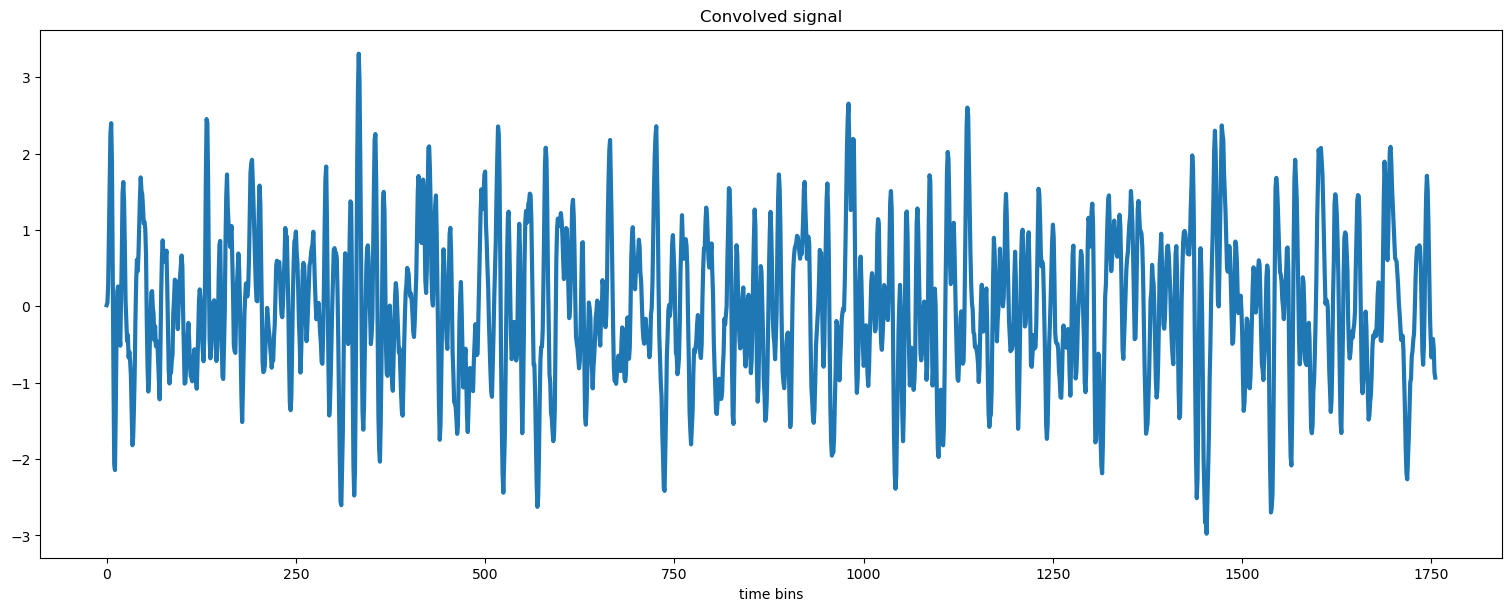

In [76]:
fig, ax = plt.subplots(figsize=(15, 6), layout="constrained")
ax.plot(convolved_signal[0], lw=3)
ax.set_xlabel("time bins")
ax.set_title("Convolved signal")
plt.show()

**Questions:** 

* why does the convolved signal have fewer time bins than the stimulus?
* is there a way to compute number of time bins in the convolved signal given a stimulus and an STA?

# 5 - Relate the convolution to spikes

Congratulations, you have the next piece of the LN puzzle: the convolved signal!

You now need to figure out the relationship between the output of the convolution and the firing response of the cell. According to our assumptions, whenever the output of the convolution is large, the firing response of the cell is also large. How would you go about verifying this?

Well, you want to find out how some change in the value of the convolved signal is translated to a change in the firing response of the cell. Since both the convolved signal and the spike train are binned in the same way, you could simply plot one against the other. 

**But do the `convolved_signal` and `training_spikes` have the same dimensions?**

No! Although they have the same number of trials, they have different numbers of time bins. More specifically, **the first `num_past_pulses - 1` bins of `convolved_signal` are truncated**. This is a result of the convolution operation. We don't have time to go into the math here, but you're encouraged to read up about it, for eg [here](https://towardsdatascience.com/convolutions-in-one-dimension-using-python-54d743f18063).

Okay, now try to plot the relationship between the `convolved_signal` and the `training_spikes`

**Exercise:** complete the code below to plot values of the convolved signal on the x-axis and the corresponding spike counts from the training set on the y-axis

In [ ]:
fig, ax = plt.subplots(layout="constrained")

## COMPLETE THE FOLLOWING LINE ##

ax.scatter(      ,        , c="tab:green", s=2)

ax.set_xlabel("Values in the Convolved Signal")
ax.set_ylabel("Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.show()

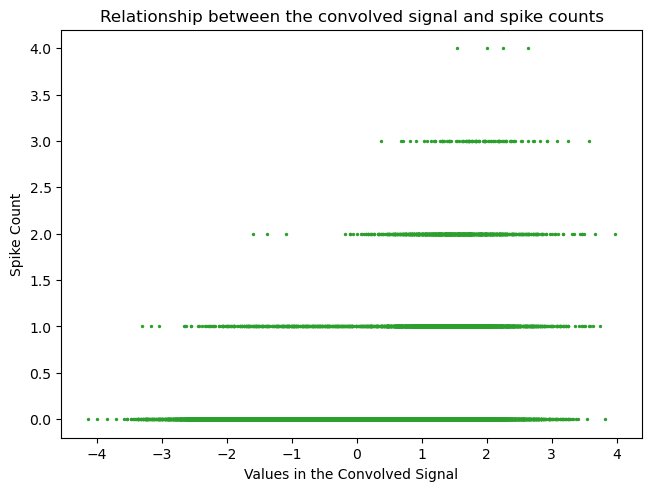

In [77]:
## SOLUTION ##

fig, ax = plt.subplots(layout="constrained")

ax.scatter(convolved_signal.ravel(), training_spikes[:, num_past_pulses-1:].ravel(), c="tab:green", s=2)

ax.set_xlabel("Values in the Convolved Signal")
ax.set_ylabel("Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.show()

This... is not very helpful, is it? Why?

When the values of the convolved signal are small, the output spike count is also small, and vice-versa. The problem here is that the **spike counts are whole numbers** (0, 1, 2, 3...), so even for a large variation in the convolution output, the spike count only jumps between neighbouring values. Moreover, the cell is not entirely reliable - for the same value of a convolved signal, it could potentially have very different firing responses. What you would ideally like to have is a **smoother transition over the range of spike counts for any change in the convolution output**.

### How do you fix this?

**By fitting a curve!**

(Well, there is a lot more nuance to it than this, but for the illustrative and educative purposes of this course, fitting a nice curve to this plot should suffice!)

# 6 - Fit a Curve

To fit a curve, you first need to decide what sort of a curve you'd like to fit. There are more than a few families of curves to choose from (and if you're more mathematically inclined, you could even come up with your own little curve that could work here). However, to keep things simple, you'll start with a simple **parametrized exponential**, the formula for which would be:

$$
f(x) = a \cdot \exp(b \cdot x + c)
$$

This is in effect just an exponential, the additional parameters allow us to fit our data a bit better.

Go ahead and define this in a function!

**Exercise:** define a parametrized exponential function, with the first input argument as `x` and the subsequent ones being `a`, `b` and `c`. **The order of arguments is important here**. Internally, make use of the fact that the input `x` will always be a numpy array.

In [ ]:
## START CODE HERE ##

def exponential(   ):
    
    return 

## END CODE HERE ##

In [78]:
## SOLUTION ##
def exponential(x, a, b, c):
    """
    A parametrized exponential.
    """
    return a * np.exp(b * x + c)

In [79]:
print(exponential(np.arange(10), 0.5, 0.5, -0.5))

[ 0.30326533  0.5         0.82436064  1.35914091  2.24084454  3.69452805
  6.09124698 10.04276846 16.55772598 27.29907502]


**Expected output:**
```
[ 0.30326533  0.5         0.82436064  1.35914091  2.24084454  3.69452805
  6.09124698 10.04276846 16.55772598 27.29907502]
```

Fantastic! Now you have a function you can fit to the data.

For the fitting itself, we'll be using the function `curve_fit` provided by the `optimize` module of the package `scipy`. This has already been imported in the notebook, but you're encouraged to go through the documentation for it.

### Curve fitting

`curve_fit` takes as input:

1. the function you want to fit, 
2. the x axis values and the y axis values from our data, 
3. bounds we'd like to enforce on our parameters, and
4. an initial set of parameters

and returns the set of optimal parameters (in the order of their input into the function).

In the parametrized exponential function, we can be relatively certain that the output of the function needs to be positive. This sets a lower bound on `a` at `0`. However, none of the other parameters have an obvious bound to them, so it's best to provide no other bound to the fitting algorithm.

Choosing the right set of initial parameters is an art unto itself, and is probably worth spending more time on than we have in this course. For now, a reasonable set of initial parameters have been chosen for you.

**Exercise:** fill out the missing arguments to the `curve_fit` function

*Hint 1:* the function argument should be without parantheses

*Hint 2:* remember to .`ravel()` the x- and y-axis values

*Hint 3:* make sure the x- and y-axis values have the same shape (!)

In [80]:
## FILL IN THE MISSING ARGUMENTS ##

optimal_parameters, _ = curve_fit(
    f=,  # the function you'd like to fit
    xdata=  # x axis values
    ydata=  # y axis values
    p0=[2.0, 0.5, -1.5],  # initial parameters
    bounds=([0, -np.inf, -np.inf], np.inf),  # bounds
    maxfev=4000,  # just making sure the algorithm converges, hehe
)

SyntaxError: invalid syntax (3787277928.py, line 4)

In [81]:
## SOLUTION ##

optimal_parameters, _ = curve_fit(
    f=exponential,  # the function we'd like to fit
    xdata=convolved_signal.ravel(),  # x axis values
    ydata=training_spikes[:, num_past_pulses - 1:].ravel(),  # y axis values
    p0=[2.0, 0.5, -1.5],  # initial parameters
    bounds=([0, -np.inf, -np.inf], np.inf),  # bounds
    maxfev=4000,  # just making sure the algorithm converges, hehe
)

In [82]:
optimal_parameters

array([ 1.9952805 ,  1.01998284, -3.57363866])

The exact fit parameters will be different for everyone, so there is only one way to check if the fit makes any sense: by plotting it!

What you want to plot is the output of the exponential function for a set of x-axis values, given the optimal parameters. In the next cell, a set of `x_values` is defined spanning the range of values you see in the data. 


What you must do is compute the exponential for those `x_values` using the optimal parameters you just calculated.

**Exercise:** complete the code to compute `y_fit`, feeding `x_values` and `optimal_parameters` as input to the exponential function

In [83]:
x_values = np.linspace(
    start=np.floor(convolved_signal.min()),
    stop=np.ceil(convolved_signal.max()),
    num=51
)

In [84]:
## COMPLETE THE FOLLOWING LINE ##

y_fit = 

SyntaxError: invalid syntax (3576655791.py, line 3)

In [85]:
## SOLUTION ##

y_fit = exponential(x_values, *optimal_parameters)

Time to see the plot!

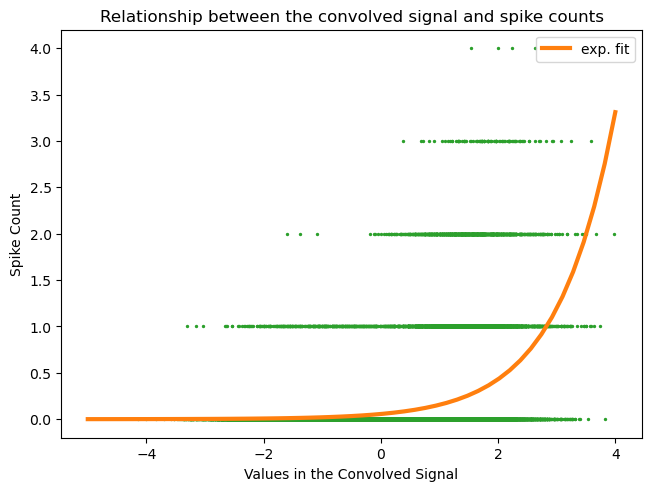

In [86]:
fig, ax = plt.subplots(layout="constrained")
ax.scatter(convolved_signal.ravel(), training_spikes[:, num_past_pulses-1:].ravel(), c="tab:green", s=2)
ax.plot(x_values, y_fit, lw=3, c="tab:orange", label="exp. fit")
ax.set_xlabel("Values in the Convolved Signal")
ax.set_ylabel("Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.legend()
plt.show()

Excellent!

You now have a smooth function that translates changes in the convolution output to changes in spiking activity.

It's time to predict!

# 7 - Predict

Prediction is the quickest part of the model. What you need to do is as follows:

1. convolve the test stimulus with the STA to get a `test_convolved` signal
2. normalize the `test_convolved` signal using the normalizing factor `training_std` computed earlier
2. pass the values of the `test_convolved` signal to the exponential function, along with the optimal parameters you computed, to get predicted responses
3. compare and plot the cell's ground truth response with the predicted response

So let's get to it - let's see if you can do this with minimal assistance...

**Exercise:** convolve the test stimulus with the cell's STA

In [87]:
## START CODE HERE ##



## END CODE HERE ##

In [88]:
## SOLUTION ##

test_convolved = convolve_stimulus_with_sta(test_stimulus[:1, :], sta)[0]

In [89]:
print(test_convolved[:10]) # first ten bins
print(test_convolved[-10:]) # last ten bins

[ 1.98519047  2.3404082   2.25785349  1.42449686  0.98418219  0.17837633
 -0.42013888 -0.0739153   0.50296651  1.38968785]
[2.79509514 2.90653527 2.46812043 1.69159021 1.11867119 0.6259971
 0.89525544 0.9529763  0.69735573 0.1196329 ]


**Expected output:**
```
[ 1.98519047  2.3404082   2.25785349  1.42449686  0.98418219  0.17837633
 -0.42013888 -0.0739153   0.50296651  1.38968785]
[2.79509514 2.90653527 2.46812043 1.69159021 1.11867119 0.6259971
 0.89525544 0.9529763  0.69735573 0.1196329 ]
```

**Exercise:** normalize the `test_convolved` signal

In [90]:
## START CODE HERE ##


## END CODE HERE ##

In [91]:
## SOLUTION ##

test_convolved /= training_std

In [92]:
print(test_convolved.std())

1.0769560345258946


**Expected output:** 
```
1.0769560345258946
```

**Exercise:** compute the predicted responses

In [ ]:
## START CODE HERE ##


## END CODE HERE ##

In [93]:
## SOLUTION ##

y_predicted = exponential(test_convolved, *optimal_parameters)

Amazing! Now it's time to see if what you predicted looks anything like the ground truth!

**Drumroll...**

...

...

...

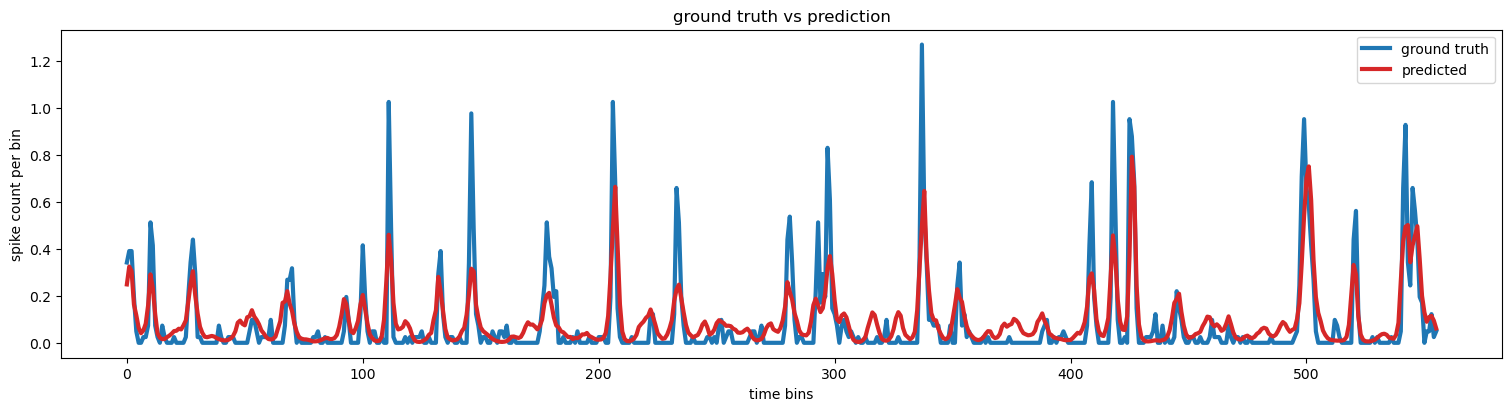

In [94]:
fig, ax = plt.subplots(figsize=(15, 4), layout="constrained")
ax.plot(ground_truth[num_past_pulses-1:], lw=3, c="tab:blue", label="ground truth") 
## NOTE: we truncated the ground truth above

ax.plot(y_predicted, lw=3, c="tab:red", label="predicted")
ax.set_xlabel("time bins")
ax.set_ylabel("spike count per bin")
ax.set_title("ground truth vs prediction")
plt.legend()
plt.show()

**Ta Da!!!**

Surprised? Disappointed?

Well, clearly, the predicted traces do follow the "tendency" of the ground truth, but don't quite manage to find the same amplitude in the peaks, nor find the quietness of the flats.

You can quantify the similarity between the predicted traces and ground truth using the **Pearson's correlation coefficient**, or **Pearson's R**. For this, you will use another `scipy` function called `pearsonr`, that's also been imported for you already.

**Exercise:** compute the Pearson's R between the predicted responses and ground truth

In [ ]:
## START CODE HERE ##


## END CODE HERE ##

In [95]:
## SOLUTION ##

r_value = pearsonr(ground_truth[num_past_pulses-1:], y_predicted)

In [96]:
print(r_value)  # THIS RESULTM

PearsonRResult(statistic=0.8343210729581831, pvalue=2.128255518493888e-145)


**Expected output:**

```
PearsonRResult(statistic=0.8129588611275091, pvalue=3.308034524901485e-132)
```

Well, maybe that is surprising for you? The **correlation coefficient between the two signals is pretty high**!

You might argue that this statistic is misleading, and you wouldn't be entirely wrong. The **correlation coefficient is sensitive to the location of the peaks and troughs in two signals, but not so much to their relative amplitudes**. As a result, our predicted trace gets a pretty high r-value, even though it clearly falls short of predicting the cell's peaks of activity.

This means that it's **important to look at the actual traces and not just the statistics** to determine how good or bad a model is.

It also means that our current implementation of the LN model is far from perfect at predicting (at least this cell's) responses. 

However, we'd also like to argue that this is **already fantastic for a model which took you one day to implement with limited experience in Python programming**. Where more sophisticated models might win in better predictive power, the LN model wins in simplicity and clarity.

The last thing to do now is to apply this model to other cells and examine the differences in model performance.

# 8 - Multiple Cells

Before you repeat this process for multiple cells, it would be best to implement a function for this. 

This will be a **big function**, and you'll have to implement it carefully. The function needs to have the following properties:

1. It implements the LN model for a single cell
2. It takes as input the spike times, stimuli, pulses, number of past frames for the sta, number of test and training frames, the fitting function, fit bounds and inital fit parameters
3. It returns a **python dictionary** containing the following keys - `prediction`, `ground_truth`,`r_val`, `fit_parameters` and `sta`
4. Internally, it repeats all the steps from the `calculate_sta` function. Ideally we would use the calculate_sta function directly, but many of the steps used in that function need to be repeated here as well. So feel free to copy the internals of the `calculate_sta` function and paste them inside this function, taking care that you're using the right variables. (it's perfectly fine if you choose not to do this, but you'll be recalculating many of the variables)

**Exercise:** complete the following function that implements the LN model for a single cell

In [ ]:
## CHECK FOR MISSING LINES IN CODE AND COMPLETE THEM ##

def ln_model(
    spike_times_array,
    stimulus_array,
    pulses_array, 
    training_frames,
    test_frames,
    past_frames,
    fit_function,
    fit_bounds,
    init_params,
):
    # reshape the stimulus and pulses using the training_frames and test_frames
    stimulus_reshaped, pulses_reshaped = 
    
    # select only those spikes which occur during the stimulus presentation
    spikes_in_stimulus = spike_times_array[  # select...
        (   ) &  # ... all spikes after the first pulse
        (   )  # ... and all spikes before the last pulse
    ]
    
    # bin the spike train using the reshaped pulses
    spikes_binned = 
    
    # reshape the binned spikes to the same shape as reshaped_pulses
    spikes_in_trials = 
    
    # split spikes into training and test
    training_spikes, test_spikes = 
    
    # split stimulus into training and test
    training_stimulus, test_stimulus = 
    
    # get stimulus snippets past_frames before each spike
    stimulus_snippets = 
    
    # average over the stimulus snippets
    sta = 
    
    # compute the ground truth responses
    ground_truth = 
    
    # convolve the training stimulus with the sta
    convolved_training = 
    # convolve the test stimulus with the sta
    convolved_test = 
    
    # compute the standard deviation of convolved_training
    norm_std = 
    
    # normalize both convolved_training and convolved_test
    
    
    # compute fit parameters
    fit_parameters, _ = curve_fit(
        f=             # the function we'd like to fit
        xdata=         # x axis values
        ydata=         # y axis values
        p0=            # initial parameters
        bounds=        # bounds
        maxfev=4000,   # just making sure the algorithm converges, hehe
    )
    
    # run the prediction on convolved_test using the fit_parameters
    prediction = 
    
    # compute pearson's r
    r_val = 
    
    # store results
    result_dict = {
        "prediction": prediction,
        "ground_truth": ground_truth[past_frames-1:],
        "r_val": r_val.statistic,
        "fit_parameters": fit_parameters,
        "sta": sta,
    }
    
    return result_dict
    

In [ ]:
## SOLUTION ##

def ln_model(
    spike_times_array,
    stimulus_array,
    pulses_array, 
    training_frames,
    test_frames,
    past_frames,
    fit_function,
    fit_bounds,
    init_params,
):
    # reshape the stimulus and pulses using the training_frames and test_frames
    stimulus_reshaped, pulses_reshaped = get_reshaped_stimulus_and_pulses(
        stimulus_array,
        pulses_array,
        training_frames,
        test_frames
    )
    
    # select only those spikes which occur during the stimulus presentation
    spikes_in_stimulus = spike_times_array[  # select...
        (spike_times_array > pulses_reshaped.ravel()[0]) &  # ... all spikes after the first pulse
        (spike_times_array < pulses_reshaped.ravel()[-1])  # ... and all spikes before the last pulse
    ]
    
    # bin the spike train using the reshaped pulses
    spikes_binned = compute_binned_spikes(
        spikes_in_stimulus,
        pulses_reshaped
    )
    
    # reshape the binned spikes to the same shape as reshaped_pulses
    spikes_in_trials = np.reshape(spikes_binned, reshaped_pulses.shape)
    
    # split spikes into training and test
    training_spikes, test_spikes = split_into_two(
        spikes_in_trials,
        training_frames
    )
    
    # split stimulus into training and test
    training_stimulus, test_stimulus = split_into_two(
        stimulus_reshaped,
        training_frames
    )
    
    # get stimulus snippets past_frames before each spike
    stimulus_snippets = get_stimulus_stack(
        training_spikes,
        training_stimulus,
        past_frames
    )
    
    # average over the stimulus snippets
    sta = stimulus_snippets.mean(axis=0)
    
    # compute the ground truth responses
    ground_truth = test_spikes.mean(axis=0)
    
    # convolve the training stimulus with the sta
    convolved_training = convolve_stimulus_with_sta(training_stimulus, sta)
    # convolve the test stimulus with the sta
    convolved_test = convolve_stimulus_with_sta(test_stimulus[:1, :], sta)[0]
    
    # compute the standard deviation of convolved_training
    norm_std = convolved_training.std()
    
    # normalize both convolved_training and convolved_test
    convolved_training /= norm_std
    convolved_test /= norm_std
    
    # compute fit parameters
    fit_parameters, _ = curve_fit(
        f=fit_function,  # the function we'd like to fit
        xdata=convolved_training.ravel(),  # x axis values
        ydata=training_spikes[:, past_frames - 1:].ravel(),  # y axis values
        p0=init_params,  # initial parameters
        bounds=fit_bounds,  # bounds
        maxfev=4000,  # just making sure the algorithm converges, hehe
    )
    
    # run the prediction on convolved_test using the fit_parameters
    prediction = fit_function(convolved_test, *fit_parameters)
    
    # compute pearson's r
    r_val = pearsonr(ground_truth[past_frames-1:], prediction)
    
    # store results
    result_dict = {
        "prediction": prediction,
        "ground_truth": ground_truth[past_frames-1:],
        "r_val": r_val.statistic,
        "fit_parameters": fit_parameters,
        "sta": sta,
    }
    
    return result_dict
    

There is no easy way to test if this function is correctly implemented, so best to run this on the all the cells and see if there are any errors!

In [ ]:
results = []

filepaths = sorted(Path('data_LN_model').glob('fullfieldnoise*.txt'))

for filepath in filepaths:
    # load spike times for each cell
    spike_times = np.loadtxt(filepath)
    
    result = ln_model(
        spike_times_array=spike_times,
        stimulus_array=stimulus,
        pulses_array=pulses,
        training_frames=nframes_training,
        test_frames=nframes_test,
        past_frames=num_past_pulses,
        fit_function=exponential,
        fit_bounds=([0, -np.inf, -np.inf], np.inf),
        init_params=[2.0, 0.5, -1.5],
    )
    
    results.append(result)

If the cell above ran without an issue, **congratualtions**! You have successfully implemented the LN model!

It's now time to plot results for all cells.

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, layout="constrained", sharex=True, sharey=True, figsize=(15, 15))

for i, result in enumerate(results):
    ax = axs.flat[i]
    
    ax.plot(result["ground_truth"], lw=2, c="tab:blue")
    ax.plot(result["prediction"], lw=2, c="tab:red")
    ax.set_title(f"cell {i+1}, pearson's r: {result['r_val']:.2f}")
    
    if i % 2 == 0:
        ax.set_ylabel("avg. spike count")
    
    if i > 5:
        ax.set_xlabel("time bins")

plt.suptitle("LN model: ground truth (blue) vs prediction (red)")
plt.show()

All together, these plots look very promising! 

For a model that makes very few assumptions and is easy to implement, it was able to predict the responses of these cells remarkably well! 

Here's a final summary, and some notes:

1. You implemented (probably) your first model that predicts the responses of retinal ganglion cells. You tested this on a full-field flicker stimulus, although there is nothing inherently preventing the model from predicting responses to other full field stimuli, assuming you have the cell's STA to begin with. 
2. In the process, you learnt how to manipulate a variety of python data structures, and we hope that you're feeling more confident with your pythonic abilities now!
3. We deliberately did not go into how to make scientific figured in Python using matplotlib because that is a whole (and much longer) course onto itself. However, the example plots in this tutorial (and the previous ones) should have given you a good idea of how to start!
4. We didn't always follow the best Python coding practices in this tutorial (or the others), but we encourage you to keep those in mind when writing Python code. It will help keep your code organized and efficient. For further reading, you can go through [this very nice tutorial](https://docs.python-guide.org/writing/style/).

# END OF TUTORIAL

Everything after this will either be put into an optional section at the end, or removed entirely.

Well, by binning the convolved signal, and obtaining a plot that looks something like this:

<center><img src="images/ln_model_cartoon.jpeg" width="600"></center>

The green dots are the same as the ones you plotted above, but each bin in the red histogram shows the **average spike count when the convolved signal values were in that bin**.

It might be worth pausing for a moment and thinking about what is happening here and why this is a good idea! Feel free to ask us / discuss with us.

To start with, let's define 30 bins between the smallest and the largest `convolved_signal` values:

In [ ]:
num_of_bins = 30

bin_edges = np.linspace(
    np.floor(convolved_signal.min()), 
    np.ceil(convolved_signal.max()), 
    num=num_of_bins + 1  # since we're defining the bin edges here, and not the bins
)

In [ ]:
bin_edges

Next, you want a function that computes the average spike counts per bin. Go ahead and fill out the function below!

**Exercise:** complete the function below which should take the convolved signal, training spikes and bin edges as input, and returns an array with the average spike counts per bin

**CAUTION**: the function assumes that the `cell_response` has the same shape as `convolution`.

In [ ]:
def get_avg_spk_cts_per_bin(
    convolution,
    cell_response,
    bin_edges,
):
    """
    Compute the average response of the cell for ranges of convolved values
    defined by the bin edges.
    """
    # initialize an array to store average counts
    avg_counts = np.zeros((bin_edges.size - 1,))
    
    # loop over the bin edges
    for b, lower_edge in enumerate(bin_edges[:-1]):
        upper_edge = bin_edges[b+1]
        
        ## START CODE HERE ##
        
        # create a numpy mask using np.where to select appropriate convolution values
        conv_mask = np.where(
            (convolution >= lower_edge) & 
            (convolution <  upper_edge)
        )
        # compute the mean response at all positions selected by the mask
        avg_response = cell_response[conv_mask].mean()
        
        ## END CODE HERE
        
        # store the average response in the storage array
        avg_counts[b] = avg_response
    
    return avg_counts

In [ ]:
y_axis = get_avg_spk_cts_per_bin(
    convolved_signal,
    training_spikes[:, num_past_pulses - 1:],
    bin_edges
)

print(y_axis)

**Expected output:**

```
[0.         0.         0.         0.02941176 0.02898551 0.00606061
 0.01866667 0.02162162 0.01901975 0.01912682 0.01178838 0.01228105
 0.0082722  0.00769027 0.0068076  0.01086694 0.02331304 0.07017818
 0.1418298  0.27354766 0.44942832 0.53728223 0.69291339 0.71468144
 0.7431694  0.64179104 0.96       1.125      2.                nan]
```

It's okay if this cell shows a big red warning. Do you know why it's throwing the warning, though? Why is there a `nan` in the array?

Now you have the **y-axis** to the plot you want! What should the corresponding **x-axis** be?

Well, the bin centers! So go ahead calculate those.

**Exercise:** compute the x-axis using the bin edges, taking the mean of the upper and lower bin edges for each bin as the bin center

In [ ]:
## START CODE HERE ##

x_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

## END CODE HERE ##

In [ ]:
print(x_axis)

**Expected output:**

```
[-5.8 -5.4 -5.  -4.6 -4.2 -3.8 -3.4 -3.  -2.6 -2.2 -1.8 -1.4 -1.  -0.6
 -0.2  0.2  0.6  1.   1.4  1.8  2.2  2.6  3.   3.4  3.8  4.2  4.6  5.
  5.4  5.8]
```

Alright, let's plot this relationship!

In [ ]:
fig, ax = plt.subplots(layout="constrained")
ax.scatter(
    convolved_signal.ravel(),
    training_spikes[:, num_past_pulses - 1:].ravel(),
    c="tab:green",
    s=2
)
ax.bar(
    x_axis, 
    y_axis + 0.1,
    width=0.36,  # change this if need be, to make plot more readable
    color=(0.0, 0.0, 0.0, 0.0),
    edgecolor=(0.9, 0.4, 0.2, 1.0),
    bottom=-0.1
)
ax.set_xlabel("Values of the Convolved Signal")
ax.set_ylabel("Average Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.plot()

This looks promising!

The histogram in red captures some of the non-linear nature of the cell's response, although not all of it. This histogram would also look different depending on how you bin the x-axis. Feel free to re-run the previous few cells with a different number of bins and see what the plot looks like (Make sure to change the `width` argument to `ax.bar` if you change the number of bins).

Would it be reasonable to expect that binning and averaging alone will capture the cell's more extreme responses (i.e. largest spike counts)?

Well, no. But this does not mean the model doesn't have any predictive power! In fact, let's first try and predict something with the model, and then see how you could improve this.

In [ ]:
def exponential(x, a, b, c):
    return a * np.exp(b * x + c)

In [ ]:
def softplus(x, a, b, c):
    return a * np.log(1 + np.exp(b * x + c))

In [ ]:
function = exponential

In [ ]:
optimal_params_data, _ = curve_fit(
    f=function,
    xdata=convolved_signal.ravel(),
    ydata=training_spikes[:, num_past_pulses-1:].ravel(),
    bounds=([0, -np.inf, -np.inf], np.inf),
    p0=[0.50, 6.00, -4.0],
)

In [ ]:
y_axis_copy = y_axis.copy()
if np.any(np.isnan(y_axis_copy)):
    for i, val in enumerate(y_axis_copy):
        if np.isnan(val) and i == 0:
            y_axis_copy[i] = 0
        if np.isnan(val) and i > 0:
            y_axis_copy[i] = y_axis_copy[i-1]

optimal_params_histogram, _ = curve_fit(
    f=function,
    xdata=x_axis,
    ydata=y_axis_copy,
    bounds=([0, -np.inf, -np.inf], np.inf),
    p0=[0.50, 6.00, -4.0],
    maxfev=4000,
)

In [ ]:
optimal_params_data

In [ ]:
optimal_params_histogram

In [ ]:
y_fit_data = function(x_axis, *optimal_params_data)
y_fit_hist = function(x_axis, *optimal_params_histogram)

In [ ]:
fig, ax = plt.subplots(layout="constrained")
ax.scatter(
    convolved_signal.ravel(),
    training_spikes[:, num_past_pulses-1:].ravel(),
    c="tab:green",
    s=2
)
ax.bar(
    x_axis, 
    y_axis + 0.1,
    width=0.36,
    color=(0.0, 0.0, 0.0, 0.0),
    edgecolor=(0.9, 0.4, 0.2, 1.0),
    bottom=-0.1
)
ax.plot(
    x_axis,
    y_fit_data,
    c="tab:blue",
    lw=2,
    label="data",
)
ax.plot(
    x_axis,
    y_fit_hist,
    c="tab:orange",
    lw=2,
    label="histogram"
)
ax.set_xlabel("Values of the Convolved Signal")
ax.set_ylabel("Average Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.legend()
plt.plot()